In [13]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Import Everything
import cv2
import matplotlib.pyplot as plt
import utils
import numpy as np
# Set image path
folder = f"./equations"

In [116]:
def sort_contours(cnts, method="left-to-right"):
	# initialize the reverse flag and sort index
	reverse = False
	i = 0
	# handle if we need to sort in reverse
	if method == "right-to-left" or method == "bottom-to-top":
		reverse = True
	# handle if we are sorting against the y-coordinate rather than
	# the x-coordinate of the bounding box
	if method == "top-to-bottom" or method == "bottom-to-top":
		i = 1
	# construct the list of bounding boxes and sort them from top to
	# bottom
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
		key=lambda b:b[1][i], reverse=reverse))
	# return the list of sorted contours and bounding boxes
	return (cnts, boundingBoxes)

In [790]:
def boundingBoxes(fileName):
    # Read Input image
    inputImage = cv2.imread(fileName)
    h,w,_ = inputImage.shape
    # inputImage = cv2.resize(inputImage, (w//5, h//5), cv2.INTER_AREA, fx=0.1, fy=0.1)
    # Deep copy for results
    inputImageCopy = inputImage.copy()
    # Convert BGR to grayscale
    grayscaleImage = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)
    # Threshold via Otsu
    threshValue, binaryImage = cv2.threshold(grayscaleImage, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # Get each bounding box
    # Find the big contours/blobs on the filtered image
    contours, hierarchy = cv2.findContours(binaryImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours,_ = sort_contours(contours)
    # contours, _ = sort_contours(contours, "top-to-bottom")


    # Expand the bounding box size
    expansion_value = 10  # Increase this value to expand the bounding boxes more
    bounding_boxes = []
    # Look for the outer bounding boxes (no children)
    for _, c in enumerate(contours):
        # Get the bounding rectangle of the current contour
        boundRect = cv2.boundingRect(c)
        
        # Expand bounding box
        rectX = max(0, boundRect[0] - expansion_value)
        rectY = max(0, boundRect[1] - expansion_value)
        rectWidth = min(inputImage.shape[1] - rectX, boundRect[2] + 2 * expansion_value)
        rectHeight = min(inputImage.shape[0] - rectY, boundRect[3] + 2 * expansion_value)
        
        # Draw expanded bounding box
        color = (0, 255, 0)
        start_X = int(rectX)
        end_X = int(start_X + rectWidth)
        start_Y = int(rectY)
        end_Y = int(start_Y + rectHeight)
        contoursImage = inputImageCopy.copy()
        bounding_boxes.append(contoursImage[start_Y:end_Y, start_X:end_X])
        cv2.rectangle(inputImageCopy, (start_X, start_Y),
                    (end_X, end_Y), color, 2)

    # Show the image with expanded bounding boxes
    bb_image = cv2.cvtColor(inputImageCopy, cv2.COLOR_BGR2RGB)
    plt.imshow(bb_image)
    return bounding_boxes

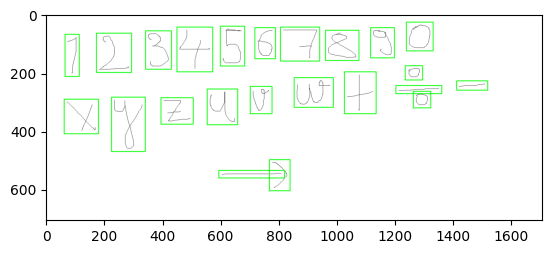

In [1029]:
fileName = f"{folder}/eq_7.png"
bounding_boxes = boundingBoxes(fileName)

In [963]:
import utils

In [1034]:
len(bounding_boxes)

23

In [933]:
from model import Sequential

In [934]:
labels = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, '-': 11, 'div': 12, 'rightarrow': 13, 'times': 14, 'u': 15, 'v': 16, 'w': 17, 'y': 18, 'z': 19}

In [935]:
def idtolabel(labels_map, y):
    for key, value in labels_map.items():
        if y == value:
            return key
        
    return -1

In [990]:
np.random.seed(42)
sequential_model = utils.load_model(model_path="./models/exp1_train_4_20231128090003.pkl")

In [937]:
bounding_boxes[0].shape

(283, 89, 3)

In [991]:
def preprocess_image(img):
    kernel = np.array([[0, -1, 0], [-1, 6, -1], [0, -1, 0]])
    img = cv2.resize(img, (45,45), cv2.INTER_AREA, fx=0.1, fy=0.1)   
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=0)
    img = cv2.dilate(img, np.ones((2,2), np.uint8), iterations=1)
    return img

In [1018]:
np.array([5,0,8,1,9]).argsort()

array([1, 3, 0, 2, 4], dtype=int64)

In [1019]:
def predict(model:Sequential, img):
    img = np.expand_dims(img, (0,1))
    img = utils.minmax_normalize(img)
    # print(img.shape, img.max())
    logits = model._forward(img)
    y_pred = np.argmax(logits, axis=1)
    print(logits.argsort(axis=1)[:, ::-1])
    return y_pred
    

In [1020]:

def get_symbols(model, bounding_boxes):
    equation_string = []
    for bb in bounding_boxes:
        preprocessed_img = utils.preprocess_image(bb)
        max_index = predict(model, preprocessed_img)
        predicted_class = idtolabel(labels, max_index)
        equation_string.append(predicted_class)

    return equation_string



In [1031]:
labels

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 '+': 10,
 '-': 11,
 'div': 12,
 'rightarrow': 13,
 'times': 14,
 'u': 15,
 'v': 16,
 'w': 17,
 'y': 18,
 'z': 19}

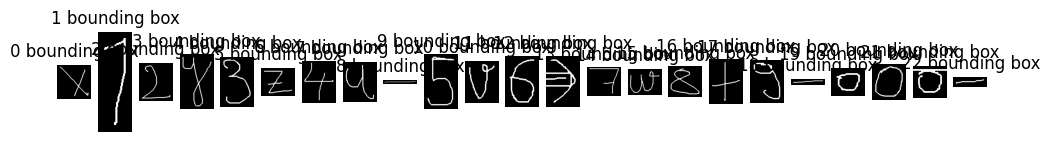

In [1035]:
utils.displayBoundingBoxes(bounding_boxes, rows=1, cols=23)

In [1032]:
symbols_list = get_symbols(sequential_model, bounding_boxes)
print(symbols_list)

[[14 18  1  3  4 19 15 16  8  5  2  9 10  7  0 13  6 17 12 11]]
[[ 7  1  3 18 16 13 19 12  0  2 15  8  5 10  9  4 14 17  6 11]]
[[ 2 18 19  5 14  3  8  1  9  7 15  6 16 12  0  4 17 13 10 11]]
[[18 19  2  8 16 14  1  4  5 10  3 15  6  9 12  7  0 17 13 11]]
[[ 3  2  5 19  1  9  0 18 13 12 15  6  8  7 14 16 10 17 11  4]]
[[19  2  3  6  5  8  9 12  0  1 18 14 15  7 16 13 10 17  4 11]]
[[ 4 11  7 18 16 14  1 10 15  2 12 19 13  0  9 17  5  3  6  8]]
[[ 1 14 10 19  4  2 15  8 16  3  7 18  9 17 12  6  5 13 11  0]]
[[11 12 13 10 17  4 15  7 19 16  1  9  0  3  5 18 14  6  8  2]]
[[ 5  3  7  9 19  2  0  8 12 13 15  6 14  4 18 16  1 17 10 11]]
[[ 0 16 18 12 15  2  7  9  5 19  1  6  4  8 13 10  3 17 14 11]]
[[ 6  5 15 12  1  0  8 19  4  2 14  3  9 17 16 10 18 13 11  7]]
[[ 4 18  7 10  0 19 16 13 15  9 12 17  8 14  3  2  1  5  6 11]]
[[ 1 10 13  3 15 14 11  7 12 17 18 19 16  5  4  2  6  9  8  0]]
[[ 1  0  2 16 18 11  6 19 14 15 10 12  5  4  7 13  3  8 17  9]]
[[ 9 19  5  3  8  2 18  0 15  1 12  4  6

In [829]:
import mnist
x_mnist_train, y_mnist_train, x_mnist_test, y_mnist_test = mnist.load()

x_mnist_train, x_mnist_test = x_mnist_train.reshape((x_mnist_train.shape[0],28, 28)), x_mnist_test.reshape((x_mnist_test.shape[0], 28, 28))

array([19], dtype=int64)

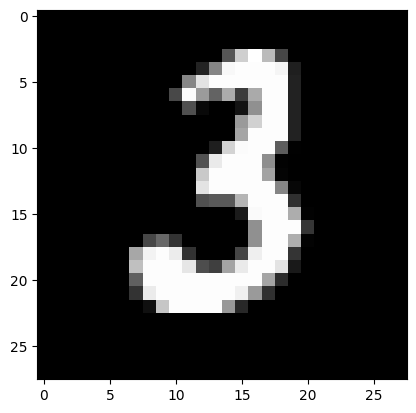

In [830]:
idx = np.random.randint(len(x_mnist_train))
plt.imshow(x_mnist_train[idx], cmap="gray")
predict(sequential_model, utils.minmax_normalize(preprocess_image(x_mnist_train[idx])))

(1, 1, 55, 55)
[4]


array([4], dtype=int64)

In [269]:
preprocess_image(x_mnist_train[0])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [301]:
def readandpreprocess(img):
    kernel = np.array([[0, -1, 0], [-1, 6, -1], [0, -1, 0]])
    img = cv2.resize(img, (55, 55), cv2.INTER_CUBIC, fx=0.1, fy=0.1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    img = cv2.dilate(img, np.ones((2, 2), np.uint8), iterations=1)
    img = cv2.filter2D(img, -1, kernel)
    return img

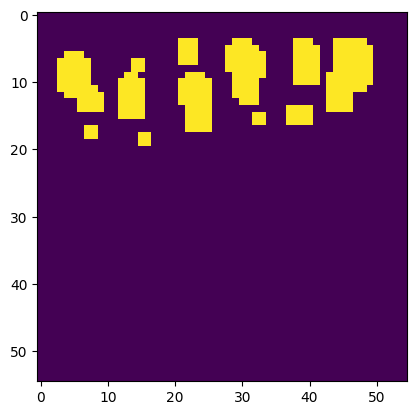

In [338]:
img = readandpreprocess("./equations/nums.png")
plt.imshow(img)

5

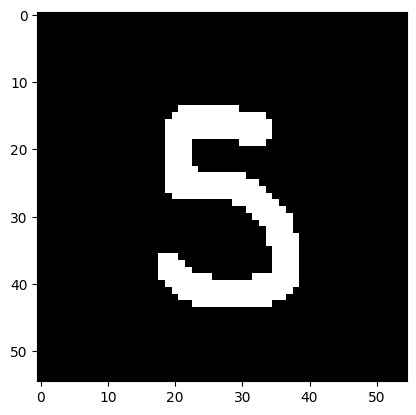

In [305]:
test_image = np.expand_dims(img, (0,1))
test_image = utils.minmax_normalize(test_image)

plt.imshow(test_image.reshape(55, 55), cmap="gray")

np.argmax(sequential_model._forward(test_image))